##  Compare the two CMIP6 AWS/s3 buckets
- the s3://cmip6-pds/ datasets are in zarr format
- the s3://esgf-world/ datasets are collections of netcdf files

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [18,4]

import matplotlib.style
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

In [3]:
zarr_cat = 'https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6-noQC.csv.gz'  
netcdf_cat ='https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.csv.gz'

In [4]:
#  read csv file, make the dataset identifiers comparable
dzarr = pd.read_csv(zarr_cat, dtype='unicode')
# vstore is same as zstore, but with the version at the end
dzarr['zstore'] = dzarr.apply(lambda row: row.zstore.split('s3://cmip6-pds/')[-1].split('CMIP6/')[-1].split('v' + str(row.version))[0], axis = 1)
dzarr['vstore'] = dzarr.apply(lambda row: row.zstore + 'v' + str(row.version)+'/', axis = 1)
dzarr = dzarr.sort_values(by=['version']).drop_duplicates(subset =["zstore"],keep='last')

In [5]:
# are some netcdf files in different versions? so we keep last version of EACH netcdf file individually
dnetcdf = pd.read_csv(netcdf_cat, dtype='unicode')

dnetcdf['zstore'] = dnetcdf.apply(lambda row: row.path.split('s3://esgf-world/CMIP6/')[-1].split(row.version)[0], axis = 1)
dnetcdf['vstore'] = dnetcdf.apply(lambda row: row.zstore + str(row.version)+'/', axis = 1)
dnetcdf['activity_id'] = dnetcdf.apply(lambda row: row.zstore.split('/')[0], axis = 1)
dnetcdf = dnetcdf.rename({'institute': 'institution_id','model': 'source_id', 'ensemble_member':'member_id',
                          'mip_table':'table_id', 'variable':'variable_id'}, axis=1)
dnetcdf = dnetcdf.sort_values(by=['version']).drop_duplicates(subset =["zstore"],keep='last')

In [6]:
# Compare number of datasets - for any version
set_L = set(dzarr.zstore.unique())
set_G = set(dnetcdf.zstore.unique())
print('AWS-zarr: ',len(set_L),' AWS-netcdf:', len(set_G),' both:', len(set_G.union(set_L)))

AWS-zarr:  471019  AWS-netcdf: 241745  both: 622998


In [7]:
dZR = dzarr[dzarr.activity_id != 'DCPP']
dNC = dnetcdf[dnetcdf.activity_id != 'DCPP']

In [8]:
m = dZR.merge(dNC, on='zstore', how='outer', suffixes=['', '_'], indicator=True)
dnot_NC = m[m._merge=='left_only']

m = dZR.merge(dNC, on='zstore', how='outer', suffixes=['_', ''], indicator=True)
dnot_ZR = m[m._merge=='right_only']

dZRnNC = dnot_NC[['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore',
       'dcpp_init_year', 'version', 'status', 'severity', 'issue_url',
       'vstore']]

dNCnZR = dnot_ZR[['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore',
       'dcpp_init_year', 'version', 'status', 'severity', 'issue_url',
       'vstore']]

print('For all activities other than DCPP:')
print('AWS-zarr:  ', len(dZR),'datasets')
print('AWS-netcdf:', len(dNC),'datasets')
print('zarrs with no matching netcdfs:',len(dZRnNC),'datasets')
print('netcdfs with no matching zarrs: ',len(dNCnZR),'datasets')

For all activities other than DCPP:
AWS-zarr:   328091 datasets
AWS-netcdf: 172126 datasets
zarrs with no matching netcdfs: 254055 datasets
netcdfs with no matching zarrs:  98090 datasets


In [9]:
def autolabel(ax,rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=10)

In [10]:
def plot_facet(df_dict,facet='table_id',top_n=8,ymax=300000,title_add=''):   
    labels = df_dict.keys()
    stables = set()
    for label in labels:
        stables = stables.union(set(df_dict[label][facet].unique()))    
    tables = sorted(list(stables))
    
    vdfs = {}
    for label in labels:
        df = df_dict[label]
        nvdf = []
        for table in tables:
            ndf = df[df[facet]==table].vstore.nunique()
            nvdf += [ndf]
        vdfs[label] = nvdf
    
    names = []
    totals = []
    for item,table in enumerate(tables):
        names += [table]
        tsum = 0
        for label in labels:
            tsum += vdfs[label][item]
        totals += [tsum]

    num_dict = {'name': names,'total':totals}
    for label in labels:
        num_dict[label] = vdfs[label]
    
    df_nums = pd.DataFrame(num_dict)  
    
    df_nums = df_nums.sort_values(by=['total'],ascending=False)
    #df_nums = df_nums.sort_values(by=[list(labels)[1]],ascending=False)

    width = 1.0/(1+len(labels))  # the width of the bars
    
    fig, ax = plt.subplots()

    names = df_nums.name.values[:top_n]
    x = np.arange(len(names)) 
    
    for item,label in enumerate(labels):
        vdf = df_nums[label].values[:top_n]
        rects = ax.bar(x - (len(labels)/2-item-0.5)*width, vdf, width, label=label)
        autolabel(ax,rects)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of Datasets')
    ax.set_title(f'Number of Datasets in AWS, top {top_n} by {facet}'+title_add)
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.set_ylim([0,ymax])
    ax.legend()

    fig.tight_layout()
    #plt.savefig(f'compare-{facet}.png')

    plt.show()

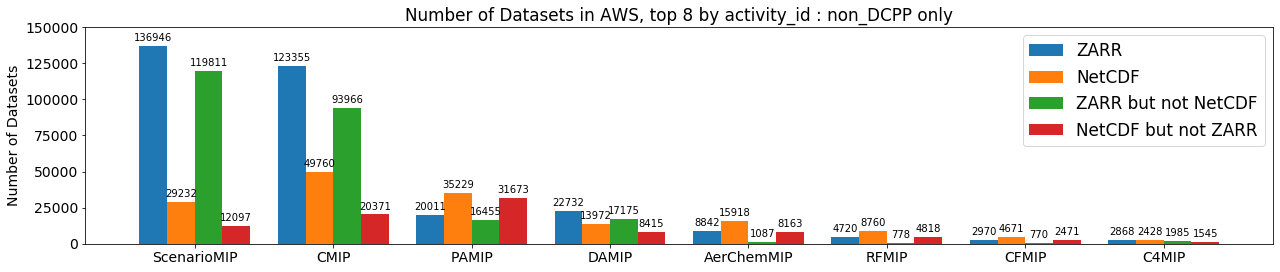

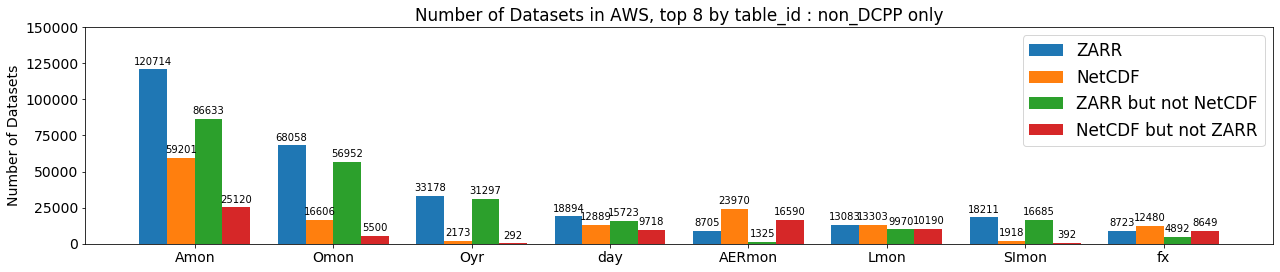

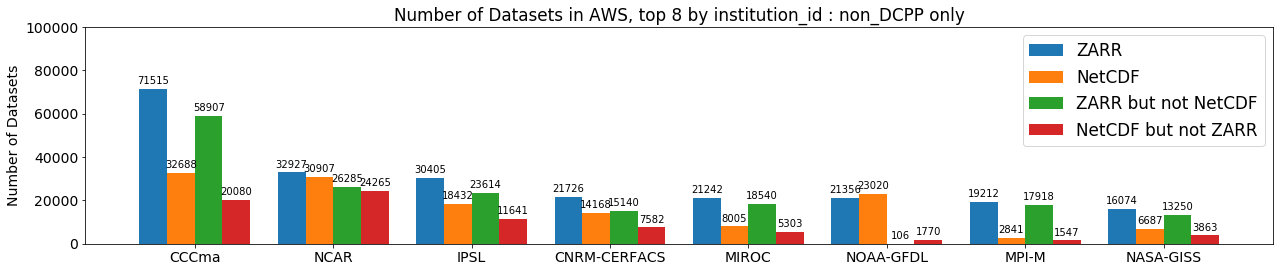

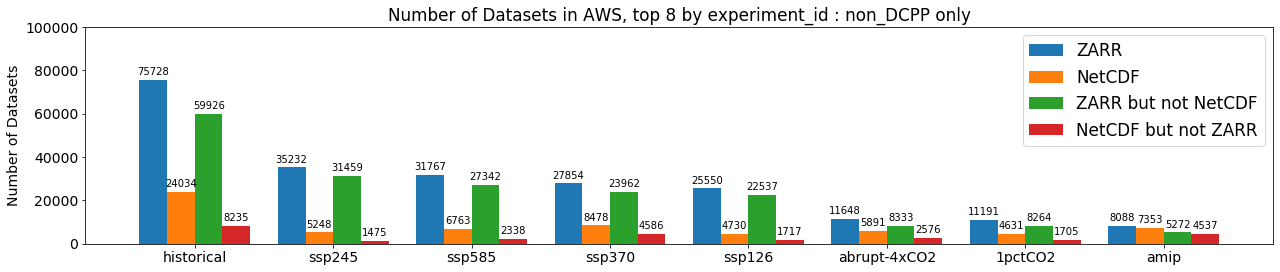

In [11]:
df_dict = {'ZARR':dZR,'NetCDF':dNC,'ZARR but not NetCDF':dZRnNC,'NetCDF but not ZARR':dNCnZR}

plot_facet(df_dict,facet='activity_id',ymax=150000,title_add = ' : non_DCPP only')
plot_facet(df_dict,facet='table_id',ymax=150000,title_add = ' : non_DCPP only')
plot_facet(df_dict,facet='institution_id',top_n=8,ymax=100000,title_add = ' : non_DCPP only')
plot_facet(df_dict,facet='experiment_id',ymax=100000,title_add = ' : non_DCPP only')

In [12]:
dZRm = dZR[dZR.table_id.str.contains('mon')]
dNCm = dNC[dNC.table_id.str.contains('mon')]
df_dict = {'ZARR':dZRm,'NetCDF':dNCm}

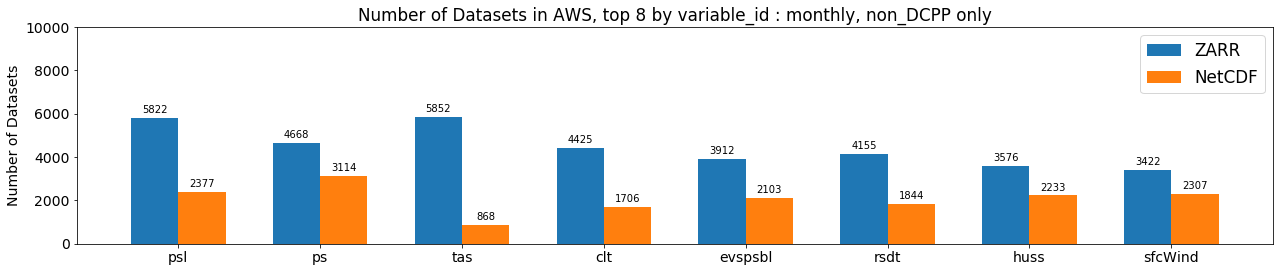

In [13]:
plot_facet(df_dict,facet='variable_id',ymax=10000,title_add = ' : monthly, non_DCPP only')